# FAONet Example
This notebook demonstrates how to use the FAONet package to load, filter and analyze FAOSTAT trade data.

First, we import the necessary libraries

In [1]:
from faonet.io import load_file
from faonet.plots import plot_trade_scatter, plot_bipartite_network2, plot_degree_bar, plot_degree_comparison, plot_degree_by_rank, plot_weight_matrix
from faonet.plots import plot_top_betweenness, plot_mean_clustering_ratio_vs_degree
from faonet.filtering import filter_top_percentile
from faonet.network import build_bipartite_network, remove_zero_weight_edges
from faonet.metrics import degree_by_group, compute_degree_and_strength, compute_betweenness_all, compute_bipartite_clustering
from faonet.export import export_gml
from faonet.fitting import fit_truncated_power_law, fit_strength_vs_degree



We load the file and choose the year we want to process

In [2]:
# Example filepaths
file = 'examples/Data/Green_Coffe_FAO_allyears.csv'
year = 2020
df = load_file(file, year = year)

## Clean up the market
Since we have country codes, we can colorize the interactions between countries, using color as the interaction value.

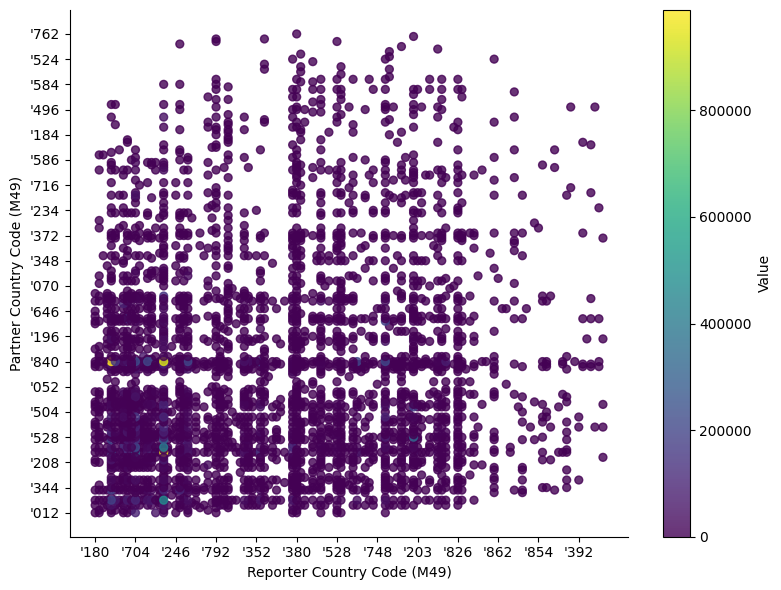

<Axes: xlabel='Reporter Country Code (M49)', ylabel='Partner Country Code (M49)'>

In [3]:
plot_trade_scatter(df)

We see that there are many very low values ​​(many purple colors) this tells us that it would be interesting to keep a percentage of the market that would allow us to better see the interactions and clean up many small interactions

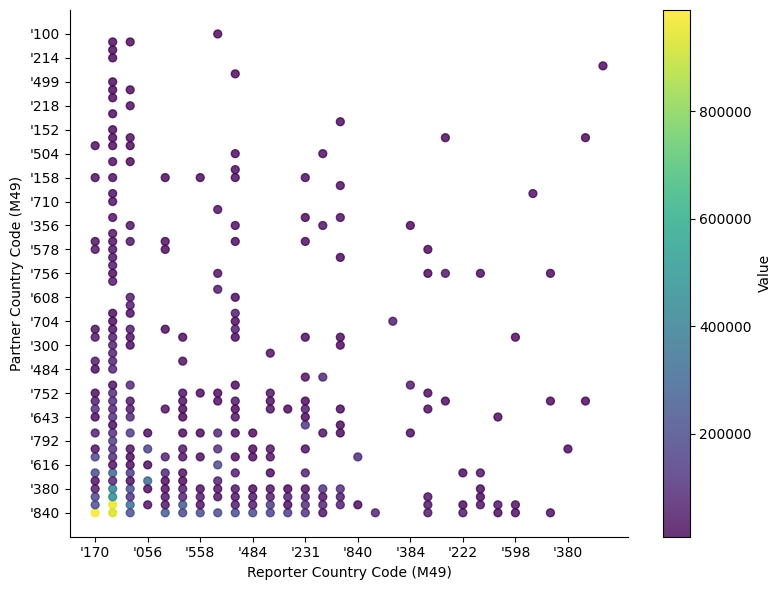

<Axes: xlabel='Reporter Country Code (M49)', ylabel='Partner Country Code (M49)'>

In [4]:
df_filtered = filter_top_percentile(df, value_column= 'Value', percentile=0.9)
plot_trade_scatter(df_filtered, step = 3)

**Now**, it seems the information is more interesting and we have left 90% of the international coffee market.

## We built the network of interactions

We built a bipartite network, with exporting and importing countries. The link width depends on the dollar value of the export.

To avoid confusion between country names, as there may be countries that act as both exporters and importers, we add '_e' to the "Reporter Countries".

In [5]:
df_filtered['Reporter Countries'] = df_filtered['Reporter Countries'] + "_e"
df_filtered.head()

,Unnamed: 0,Reporter Country Code,Reporter Country Code (M49),Reporter Countries,Partner Country Code,Partner Country Code (M49),Partner Countries,Item Code,Item Code (CPC),Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,cumsum,cumperc
36947,23426847,44,'170,Colombia_e,231,'840,United States of America,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,988368.0,A,988368.0,0.053049
37650,24248428,21,'076,Brazil_e,79,'276,Germany,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,965856.0,A,1954224.0,0.104889
52861,38953169,21,'076,Brazil_e,231,'840,United States of America,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,929346.0,A,2883570.0,0.154770
15434,9600053,21,'076,Brazil_e,255,'056,Belgium,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,467391.0,A,3350961.0,0.179856
41106,27807427,21,'076,Brazil_e,106,'380,Italy,656,'01610,"Coffee, green",5922,Export value,2020,2020,1000 USD,417441.0,A,3768402.0,0.202262


In [6]:

# Build network
G, exporters, importers = build_bipartite_network(df_filtered, 'Reporter Countries', 'Partner Countries', 'Value')
G = remove_zero_weight_edges(G)

# Export to GML
export_gml(G, 'trade_network.gml')

<Axes: title={'center': 'Bipartite Network: Exporters vs Importers in year 2020'}>

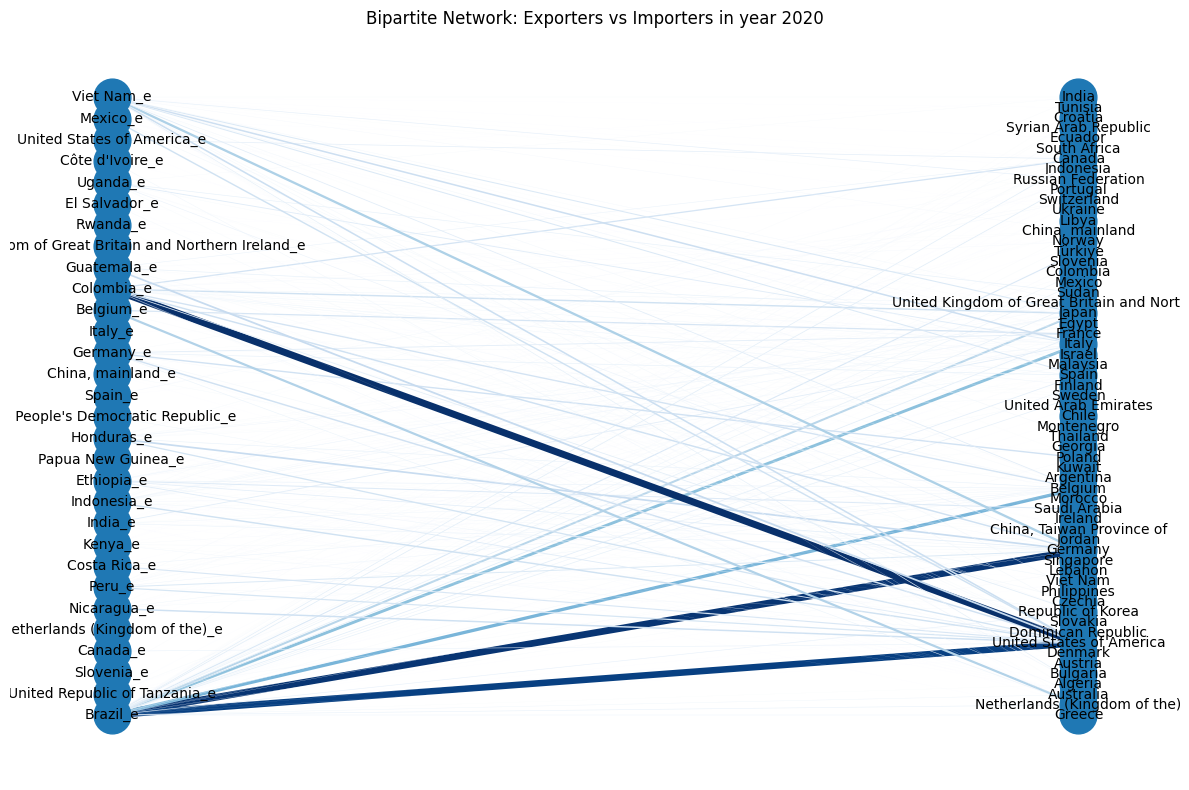

In [7]:

plot_bipartite_network2(G, group0_nodes=exporters, title="Bipartite Network: Exporters vs Importers in year 2020")

## Studying the Properties of Bipartite Networks

### Degree
The first thing usually studied is the degree of the networks. In this case, since they are bipartite, we must study the in-degree and out-degree.

Remember that the degree is the number of incoming or outgoing links, that is, the number of countries that export (out-degree) out of the number of countries that import (in-degree).

To study this, we do the following:

We calculate the degrees of exporters and importers.
We plot the histograms with the countries sorted by their degree.

In [8]:
# Compute degree
degree_export = degree_by_group(G, exporters)
print(degree_export.head())

degree_import = degree_by_group(G, importers)
print(degree_import.head())

                             Node  Degree
0                        Brazil_e      47
1   United Republic of Tanzania_e       5
2                      Slovenia_e       1
3                        Canada_e       1
4  Netherlands (Kingdom of the)_e       2
                           Node  Degree
0                        Greece       3
1  Netherlands (Kingdom of the)       7
2                     Australia       8
3                       Algeria       4
4                      Bulgaria       1


### Degree Distribution Graphs

To get an idea of ​​network behavior, one of the most interesting variables is to plot degree distributions.

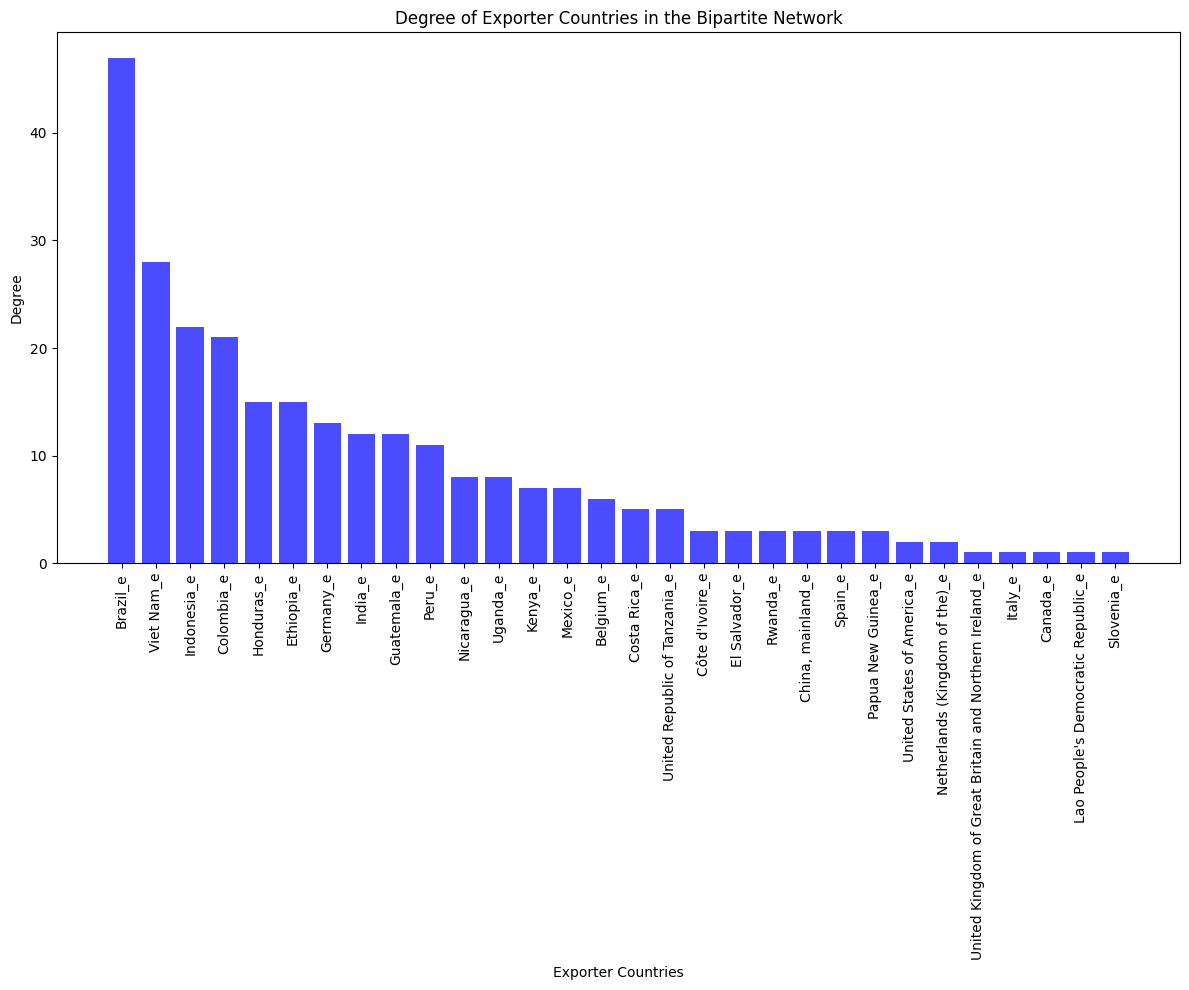

<Axes: title={'center': 'Degree of Exporter Countries in the Bipartite Network'}, xlabel='Exporter Countries', ylabel='Degree'>

In [9]:

plot_degree_bar(degree_export,
                country_col="Node",
                degree_col="Degree",
                figsize=(12, 10),
                title="Degree of Exporter Countries in the Bipartite Network",
                xlabel="Exporter Countries",
                ylabel="Degree")

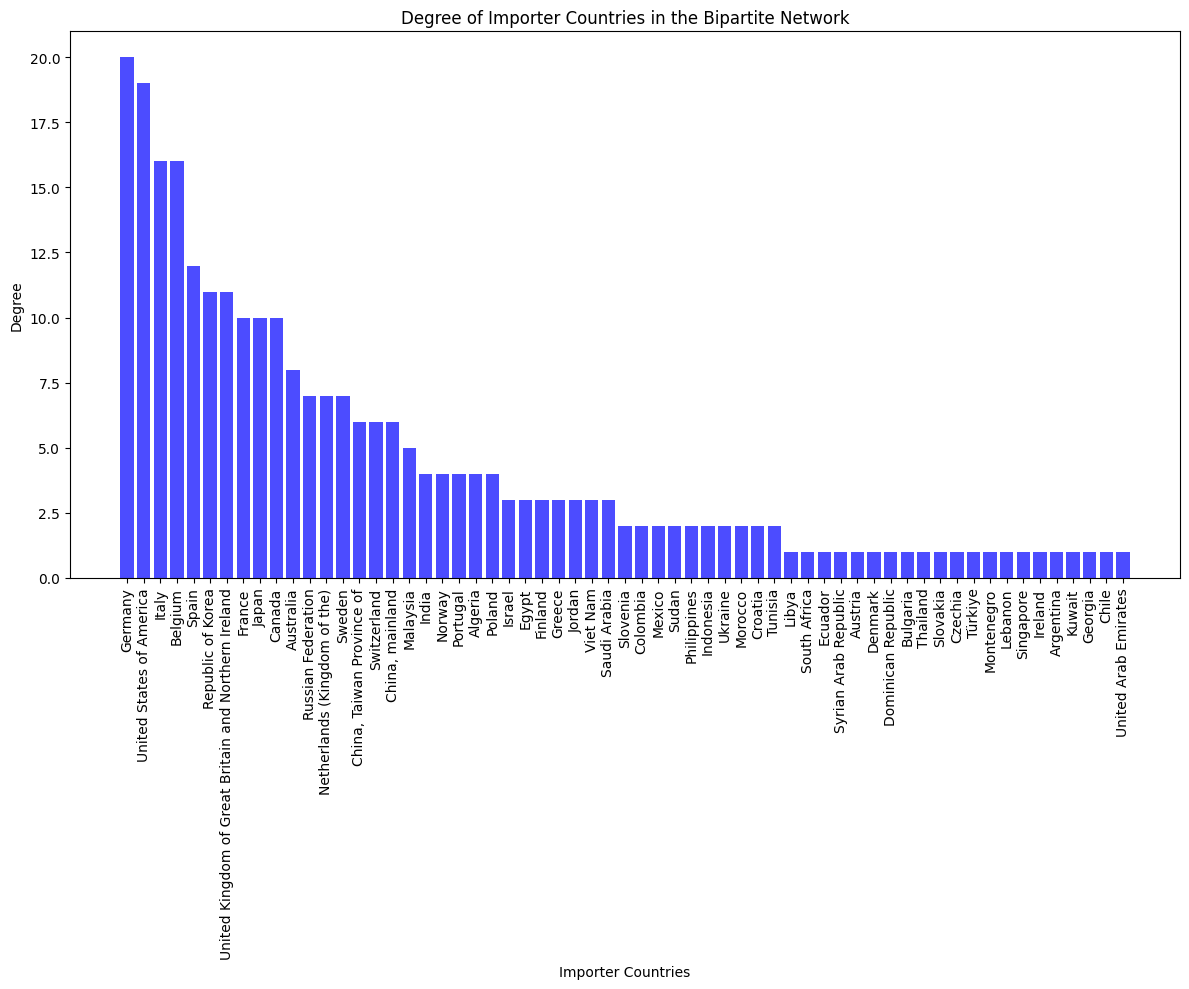

<Axes: title={'center': 'Degree of Importer Countries in the Bipartite Network'}, xlabel='Importer Countries', ylabel='Degree'>

In [10]:

plot_degree_bar(degree_import,
                country_col="Node",
                degree_col="Degree",
                figsize=(12, 10),
                title="Degree of Importer Countries in the Bipartite Network",
                xlabel="Importer Countries",
                ylabel="Degree")

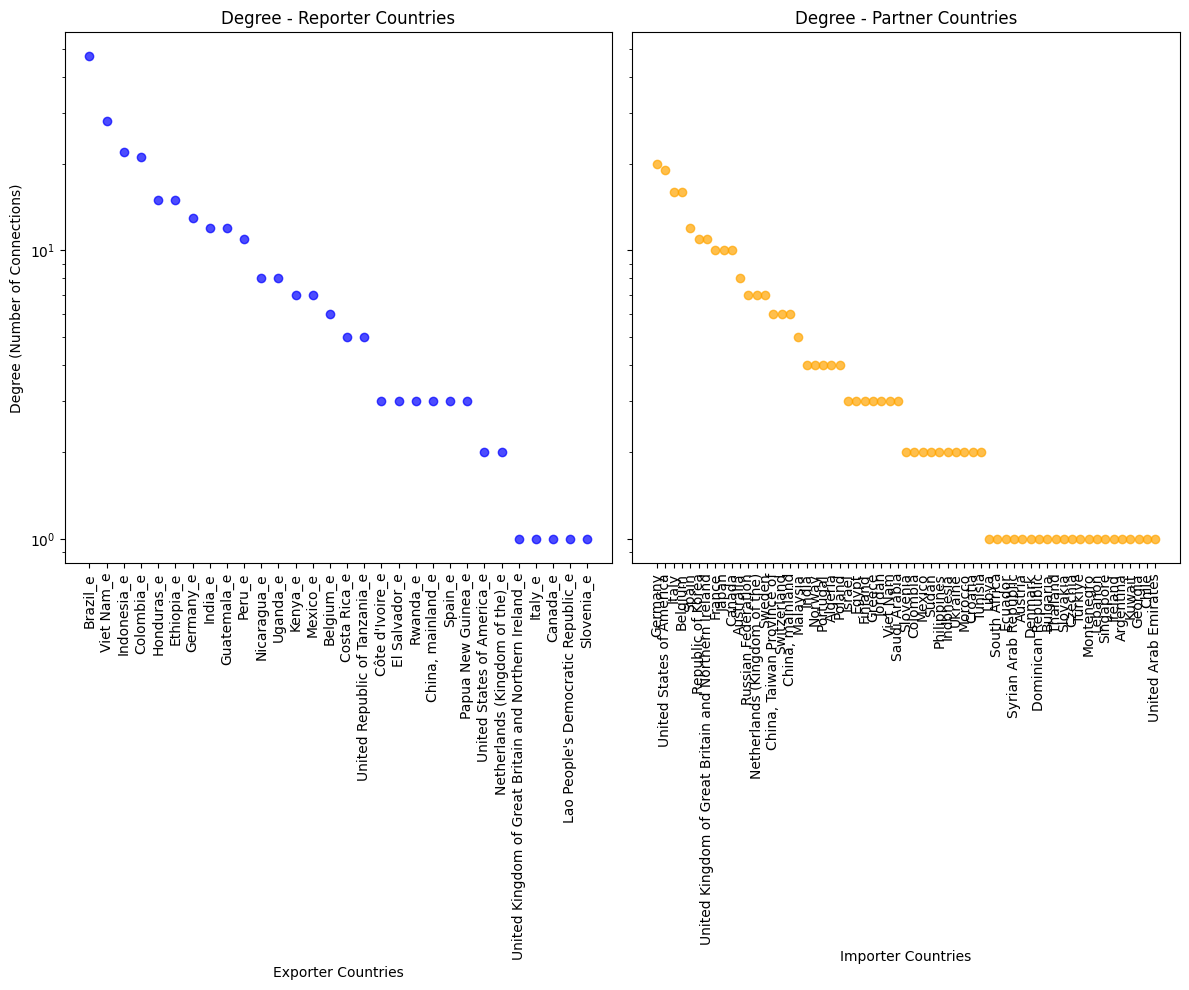

In [11]:
plot_degree_comparison(degree_export, degree_import, reporter_country_col="Node", partner_country_col="Node",use_log_scale=True)

In order to better understand the behavior of the degree distribution and to be able to compare the behaviors, we draw the degree on the y-axis and the **range** on the x-axis, that is, from the country with the highest degree to the lowest.

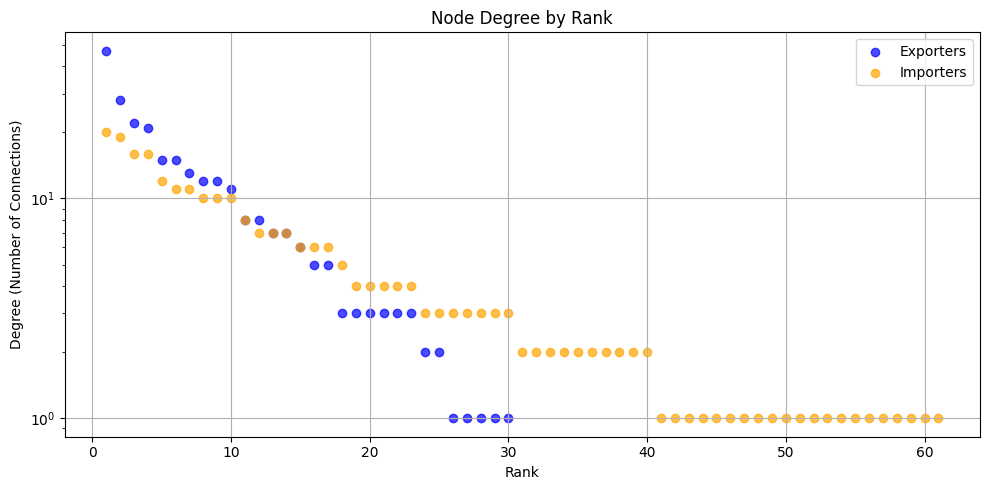

<Axes: title={'center': 'Node Degree by Rank'}, xlabel='Rank', ylabel='Degree (Number of Connections)'>

In [12]:

plot_degree_by_rank(degree_export, degree_import,use_log_x=False)

### Fitting the degree distributions.

Finally, we fit the degree distributions using a **truncated power law**, which is the curve that best fits.

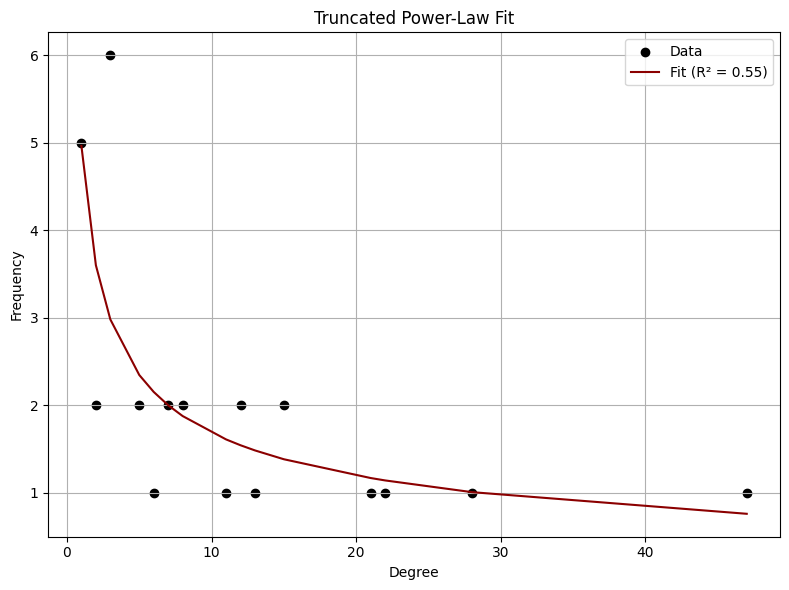

{'parameters': {'a': np.float64(4.9750656024949365), 'b': np.float64(0.45970906737613243), 'c': np.float64(439.6270971197122)}, 'r_squared': np.float64(0.5487094272889529), 'x': array([ 1,  2,  3,  5,  6,  7,  8, 11, 12, 13, 15, 21, 22, 28, 47]), 'y': array([5, 2, 6, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1]), 'fit': array([4.96376191, 3.60111386, 2.98193542, 2.34712712, 2.1535175 ,
       2.00163317, 1.87817993, 1.61136743, 1.54466735, 1.48547942,
       1.38458921, 1.17008481, 1.14272516, 1.00894334, 0.76153588])}


In [13]:
df_reporter_degrees_sorted = degree_export.sort_values(by="Degree", ascending=False)


result_exp = fit_truncated_power_law(df_reporter_degrees_sorted['Degree'])
print(result_exp)

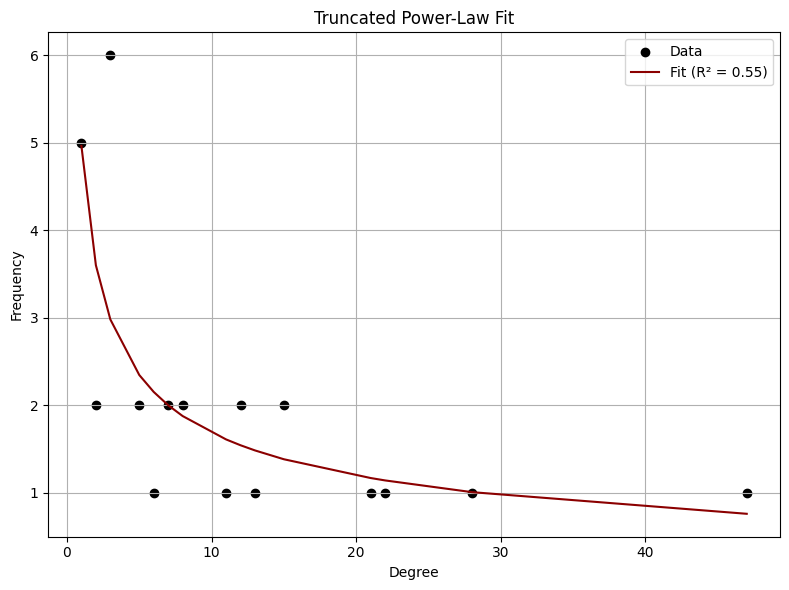

{'parameters': {'a': np.float64(4.9750656024949365), 'b': np.float64(0.45970906737613243), 'c': np.float64(439.6270971197122)}, 'r_squared': np.float64(0.5487094272889529), 'x': array([ 1,  2,  3,  5,  6,  7,  8, 11, 12, 13, 15, 21, 22, 28, 47]), 'y': array([5, 2, 6, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1]), 'fit': array([4.96376191, 3.60111386, 2.98193542, 2.34712712, 2.1535175 ,
       2.00163317, 1.87817993, 1.61136743, 1.54466735, 1.48547942,
       1.38458921, 1.17008481, 1.14272516, 1.00894334, 0.76153588])}


In [14]:
df_partner_degrees_sorted = degree_import.sort_values(by="Degree", ascending=False)

result_imp = fit_truncated_power_law(df_reporter_degrees_sorted['Degree'])
print(result_imp)

## Strength Calculation

When we have heavy networks, in addition to studying the degree, we must study the **strength**, which is the sum of the weights of the interactions. It is also interesting to see the relationship between degree and strength.

In [15]:
df_exporters, df_importers = compute_degree_and_strength(G, exporters, importers)

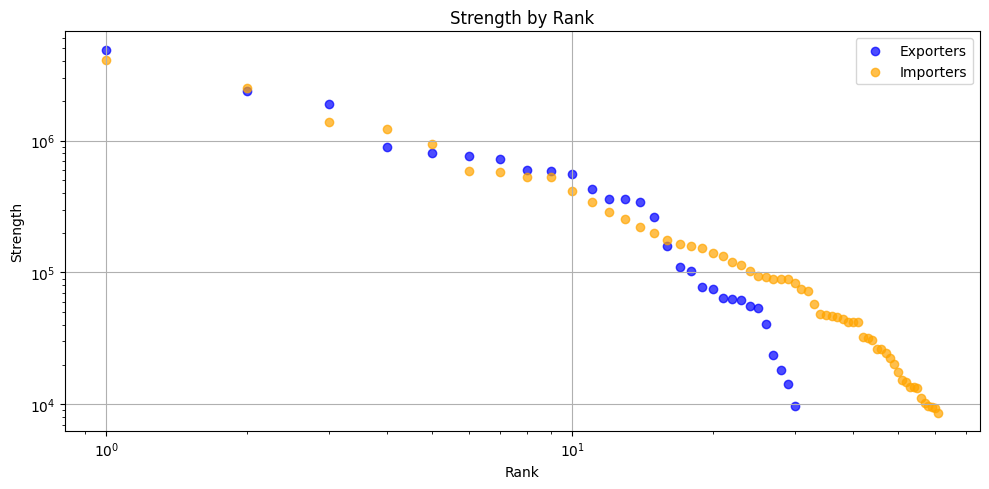

<Axes: title={'center': 'Strength by Rank'}, xlabel='Rank', ylabel='Strength'>

In [16]:
plot_degree_by_rank(df_exporters,df_importers, degree_col="Strength", title="Strength by Rank",ylabel="Strength", use_log_x=True)

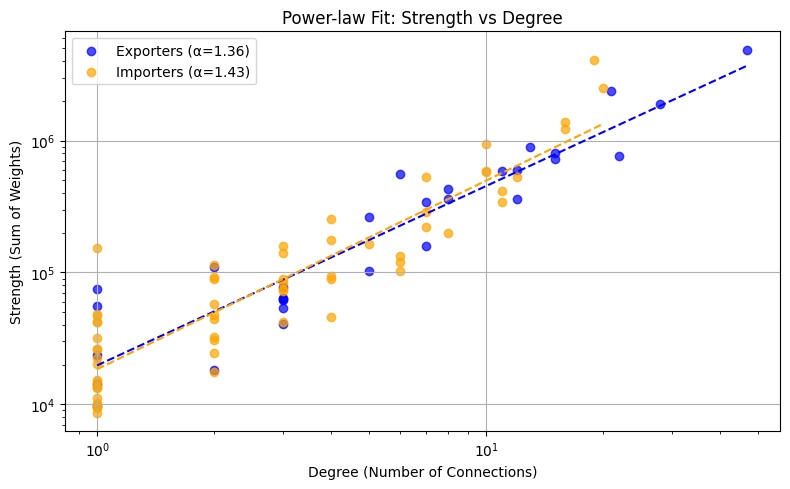

1.3589975978312931 0.8741563399702008


In [17]:
result = fit_strength_vs_degree(df_exporters, df_importers)
print(result["exporters"]["slope"], result["exporters"]["r_squared"])

When we represent strength vs. degree, they behave like a power law. If the exponent is 1, it means that the distribution of weights is completely random based on the degree. Since the exponent $α$ is greater than 1 in both cases, this suggests that countries with a higher degree have a greater strength than would correspond to them randomly. Therefore, the market is concentrated in countries with a higher degree.

## Weight matrix
We plot the weight matrix on a heatmap to see the interaction. It is confirmed that the core of interactions also has a greater weight (as seen in the color of the interactions).

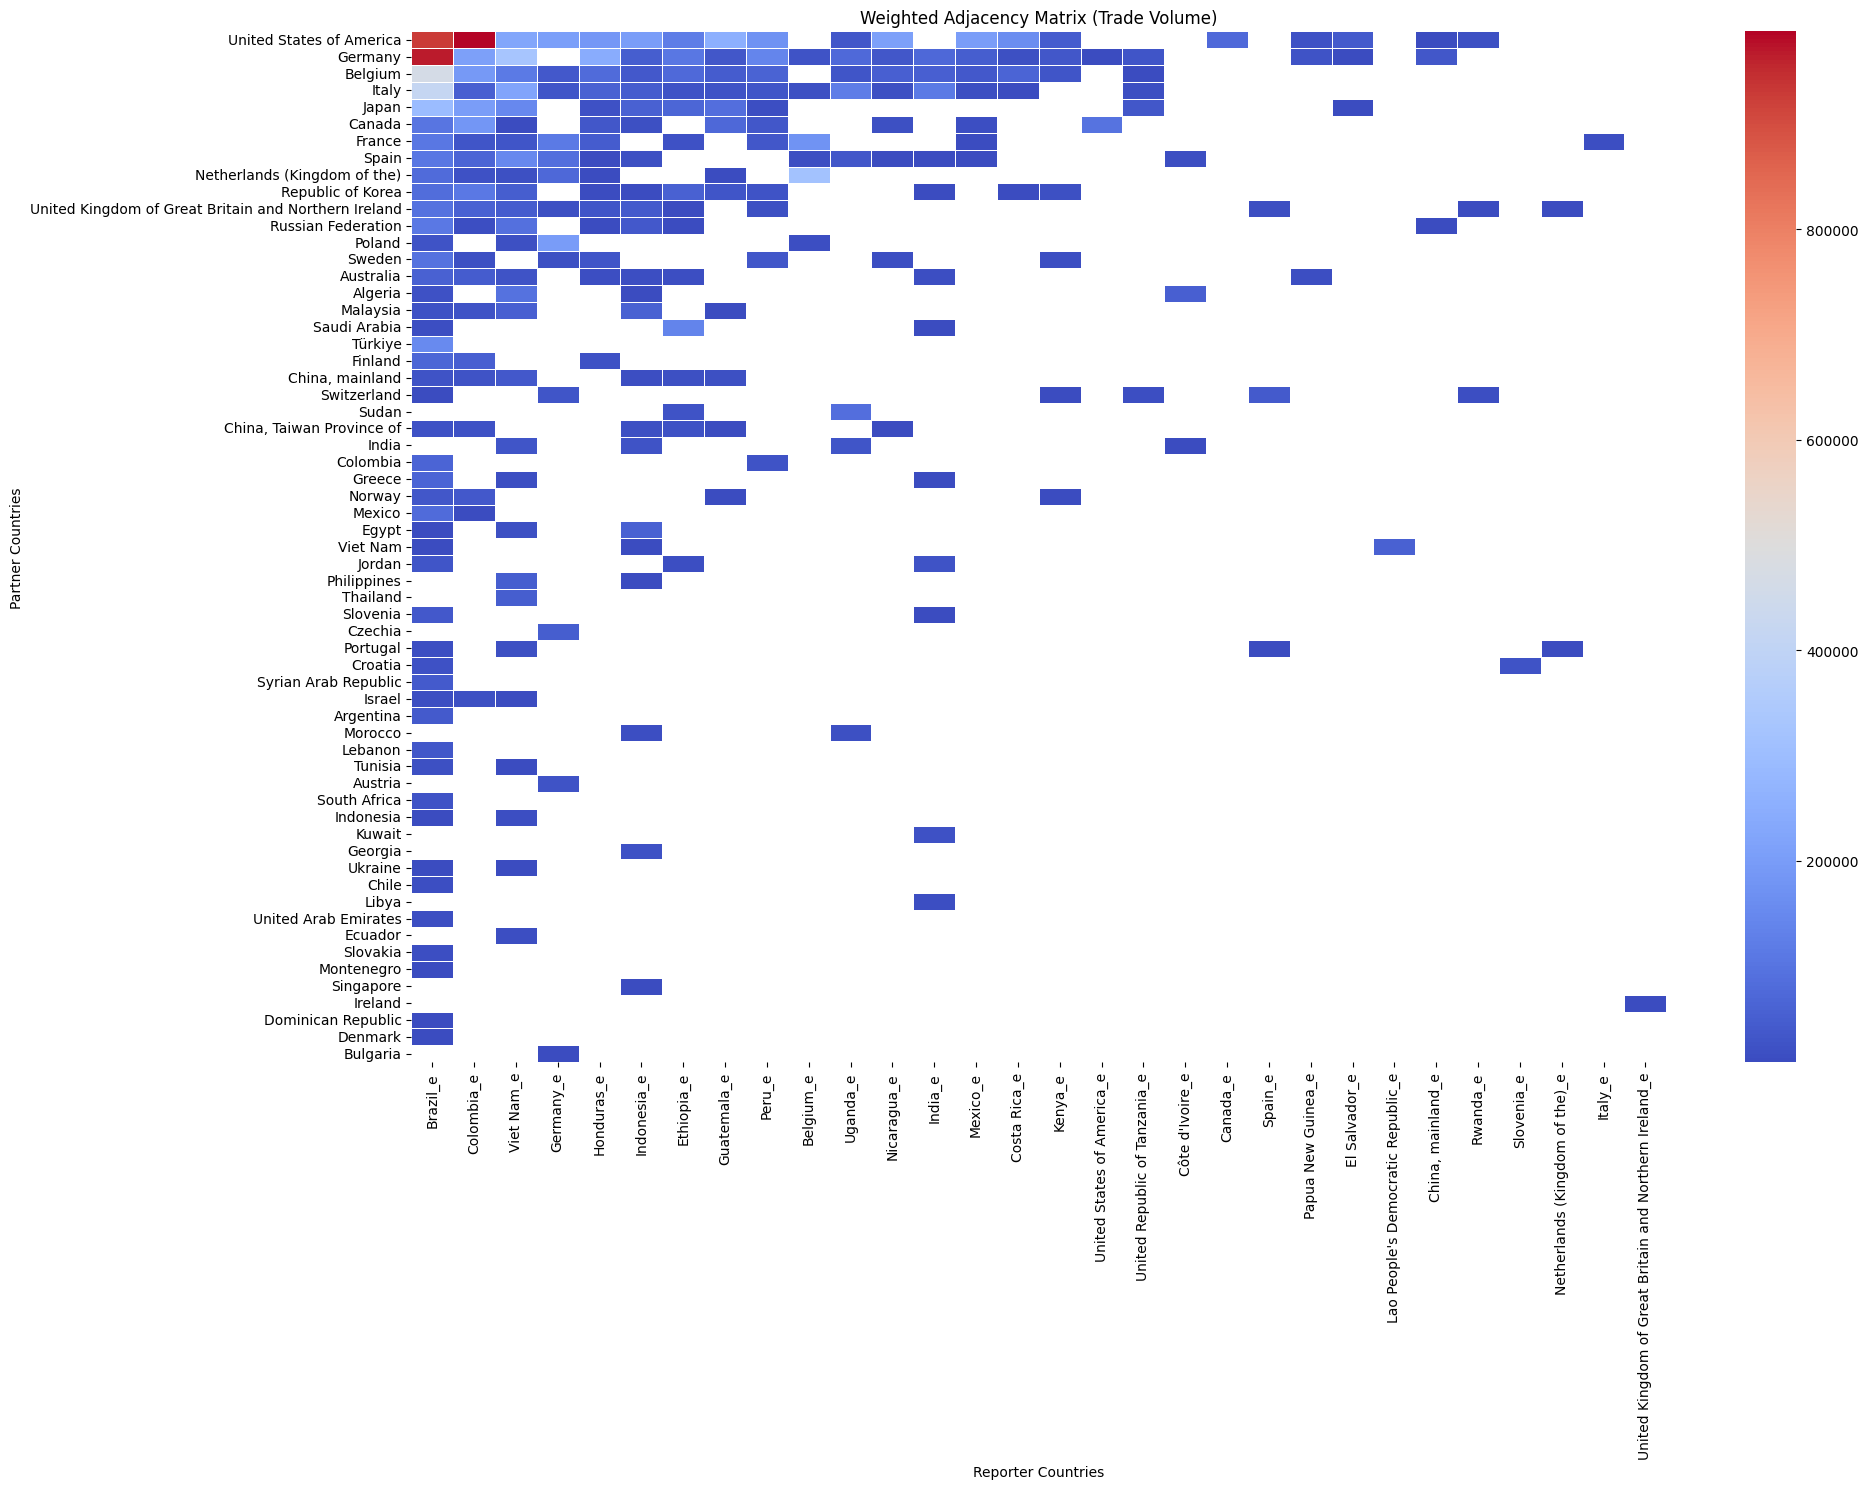

<Axes: title={'center': 'Weighted Adjacency Matrix (Trade Volume)'}, xlabel='Reporter Countries', ylabel='Partner Countries'>

In [18]:
plot_weight_matrix(df_filtered)

## Betweenness

Another interesting property to study in networks is **betweenness**.

📌 About calculating betweenness centrality in bipartite networks

In theory, the NetworkX betweenness centrality algorithm works on any network. However:
- If we apply it directly to the bipartite network, we obtain paths that only respect the original structure (without projection).
- If we project the network onto one of the sets (for example, only exporters), we can interpret how nodes of the same type are indirectly related through the other set.

In [19]:

df_bet = compute_betweenness_all(G)
title = "betweenness_centrality_"+ str(year) + ".csv"
df_bet.to_csv(title, index=False)

In [20]:
df_bet.head()

,node,bipartite_set,betweenness_bipartite,betweenness_bipartite_inv,betweenness_proj_exporters,betweenness_proj_exporters_inv,betweenness_proj_importers,betweenness_proj_importers_inv
0,Brazil_e,0,0.377528,0.657678,0.097736,0.428748,NaN,NaN
1,United Republic of Tanzania_e,0,0.025218,0.000000,0.010680,0.000000,NaN,NaN
2,Slovenia_e,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
3,Canada_e,0,0.000000,0.000000,0.318336,0.000000,NaN,NaN
4,Netherlands (Kingdom of the)_e,0,0.025218,0.000000,0.021043,0.000000,NaN,NaN


📌 Recommendation
- Use "weight" when the weights represent costs, distances, or times.
- Use "inv_weight" when the weights represent volume, frequency, or value (as in the case of coffee).

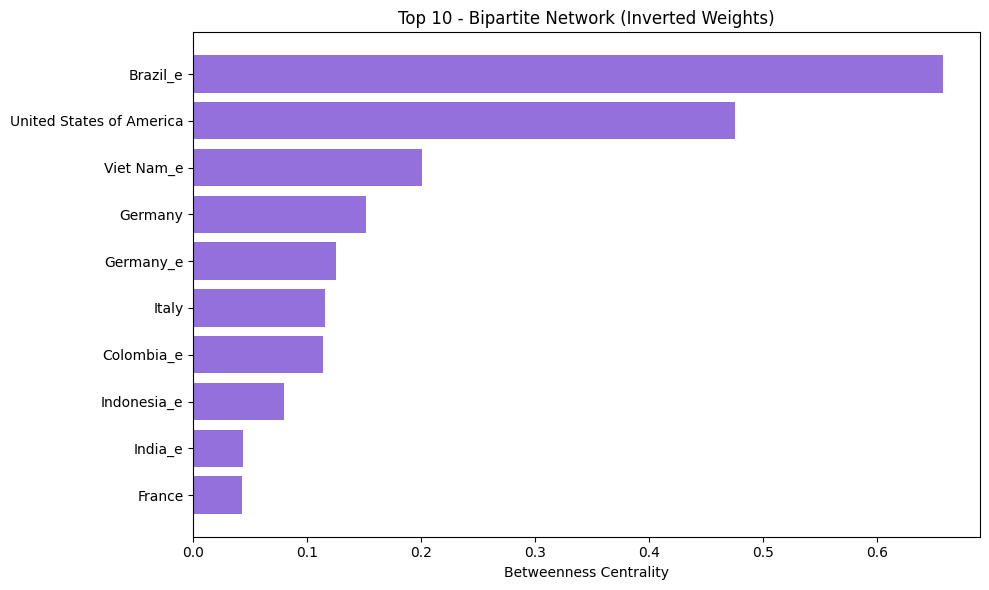

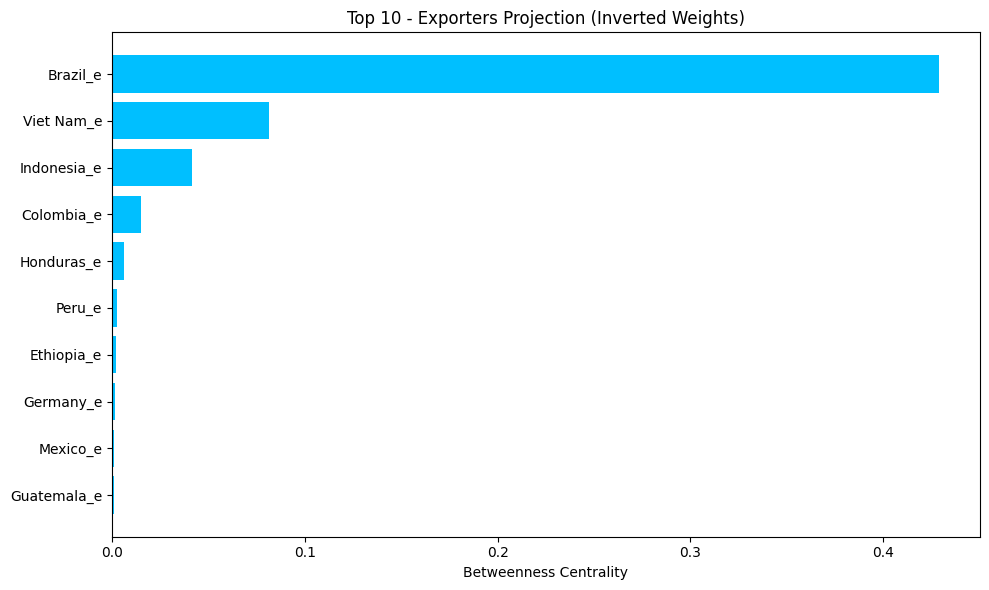

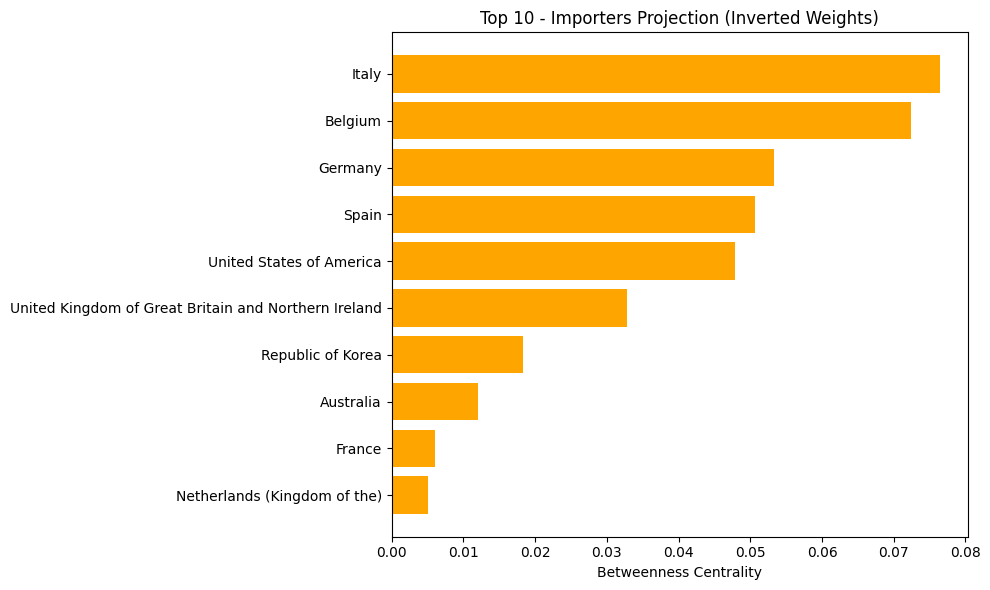

<Axes: title={'center': 'Top 10 - Importers Projection (Inverted Weights)'}, xlabel='Betweenness Centrality'>

In [21]:
plot_top_betweenness(df_bet, "betweenness_bipartite_inv", "Top 10 - Bipartite Network (Inverted Weights)", "mediumpurple")
plot_top_betweenness(df_bet, "betweenness_proj_exporters_inv", "Top 10 - Exporters Projection (Inverted Weights)", "deepskyblue")
plot_top_betweenness(df_bet, "betweenness_proj_importers_inv", "Top 10 - Importers Projection (Inverted Weights)", "orange")

If the inverted value of the peso is used.

🟣 Bipartite network: - Nodes that act as effective bridges between exporters and importers, considering the economic value of trade. - High peso = lower cost of the routes → higher probability of passing through that node.

🔵 Exporter projection: - Identifies exporters that are located in the middle of intense trade routes between other exporters. - Represents a type of indirect trade mediation.

🟢 Importer projection: - Similar, but focused on importers that share key suppliers and are located on higher-volume routes.

## Clustering Coefficient

So far, we have measured typical node properties. To measure the structural organization of a network, we can explore other measures such as the clustering coefficient. The clustering coefficient can have significant implications for how quickly a disturbance propagates through the network (Pastor-Satorras and Vespignani 2001). It is therefore an important parameter in studying the propagation of disturbances, such as crop failures, in the international coffee market.

In the case of unipartite networks, the goal is to count the number of triangles in the network based on the total number of triangles that could be formed. The problem is that in the case of bipartite networks, triangles cannot be formed, since nodes in the same group, for example, from exporting countries, have no links between them. Therefore, Gilarranz et al. (2012) proposed a method to calculate the clustering coefficient using 4-connection cycles.

In [22]:
df_c4b = compute_bipartite_clustering(G)
df_c4b.head()

,node,C4b,C4b^w,degree,C4_rate,tipo
0,Brazil_e,0.038390,0.001910,47,0.049745,Exportador
1,United Republic of Tanzania_e,0.340909,0.067985,5,0.199422,Exportador
2,Slovenia_e,0.000000,0.000000,1,NaN,Exportador
3,Canada_e,0.000000,0.000000,1,NaN,Exportador
4,Netherlands (Kingdom of the)_e,0.300000,0.150000,2,0.500000,Exportador


<Axes: title={'center': 'Mean clustering ratio ⟨C4b^w / C4b⟩ vs. Degree by node type'}, xlabel='Degree', ylabel='⟨C4b^w / C4b⟩'>

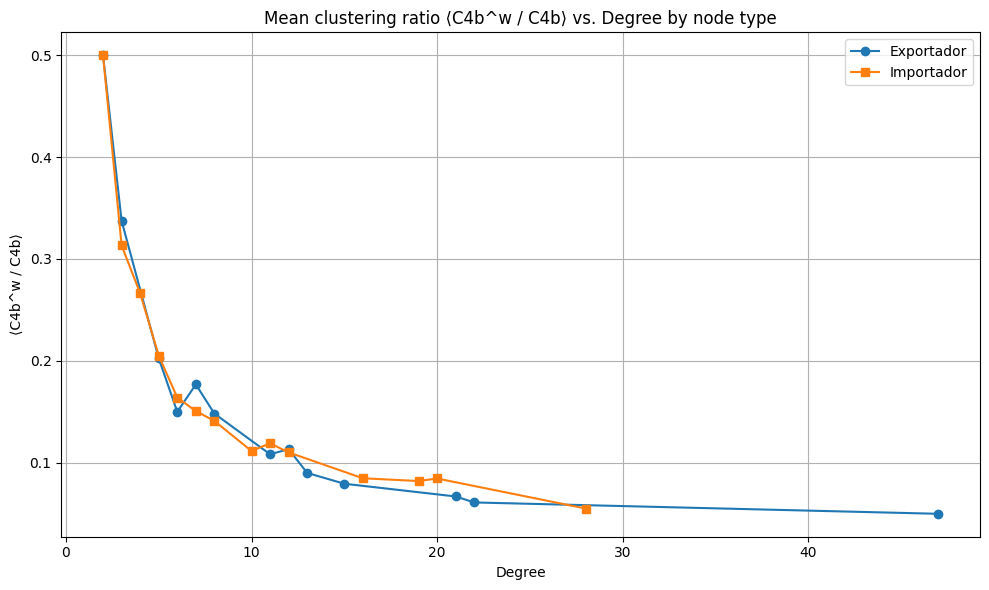

In [23]:

plot_mean_clustering_ratio_vs_degree(df_c4b, show_labels=False)

📌 What does all our analysis tell us?

1. High-degree nodes (hubs) are strongly connected to each other, but…

2. They don't form dense, strongly interconnected clusters in which all their neighbors also interact strongly with each other.

3. Hubs may be connected to many peripheral nodes (specialists), which dilutes the average weight of the quadrilaterals.

**Let's look at an example**

Imagine that Brazil exports coffee to the US, Germany, Japan, etc. in large volumes (high strength, high degree). But these importers don't necessarily trade much with other common exporters—triangles (quadrilaterals, in the bipartite case) exist, but are not reinforced by weight.
